# Untitled Notebook

What's this notebook about?

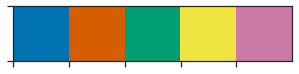

In [50]:
import re
import sys
import os
from glob import glob
import random
from collections import Counter, defaultdict
import itertools as it

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib_venn as vn
from matplotlib.colors import ListedColormap
import seaborn as sns


## Default plotting params

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=1.4, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [38]:
def get_gtf_attribute(gtf_record, attribute):
    try:
        attr = re.search(f'{attribute} "(.+?)";', gtf_record[8]).group(1)
    except AttributeError:
        raise ValueError(
            f'Could not parse attribute {attribute} '
            f'from GTF with feature type {record[2]}'
        )
    return attr


locus2gene = defaultdict(set)
with open('../../nanopore_apa_pipeline/pipeline/assembly/merged_nanopore_assembly.gtf') as gtf:
    for record in gtf:
        record = record.split('\t')
        if record[2] == 'transcript':
            locus_id = get_gtf_attribute(record, 'locus')
            gene_id = get_gtf_attribute(record, 'gene_id')
            if re.match('AT[1-5]G\d{5}', gene_id):
                locus2gene[locus_id].add(gene_id)

locus2gene = {k: ','.join(v) for k, v in locus2gene.items()}

In [39]:
RESULTS_COLUMNS = [
    'chrom', 'start', 'end', 'locus_id', 'score', 'strand',
    'wass_dist', 'wass_dir', 'wass_pval', 'wass_fdr',
    'nreads_cntrl', 'nreads_treat'
]

fpa_vs_col0 = pd.read_csv(
    '../pipeline/apa_results/fpa8_vs_col0.apa_results.bed',
    sep='\t',
    names=RESULTS_COLUMNS
)
fpa_vs_col0['gene_ids'] = fpa_vs_col0.locus_id.map(locus2gene)

FPAox_vs_col0 = pd.read_csv(
    '../pipeline/apa_results/35SFPA_vs_col0.apa_results.bed',
    sep='\t',
    names=RESULTS_COLUMNS
)

FPAox_vs_col0['gene_ids'] = FPAox_vs_col0.locus_id.map(locus2gene)


FPAox_vs_col0.head()

,chrom,start,end,locus_id,score,strand,wass_dist,wass_dir,wass_pval,wass_fdr,nreads_cntrl,nreads_treat,gene_ids
0,1,5885,13714,RLOC_00000002,69,-,68.8,-11.4,0.74200,1.0000,189,282,"AT1G01030,AT1G01020"
1,1,23139,31249,RLOC_00000004,26,+,26.1,7.3,0.96000,1.0000,212,306,AT1G01040
2,1,31115,33315,RLOC_00000006,12,-,11.8,-3.1,1.00000,1.0000,511,799,AT1G01050
3,1,33364,37871,RLOC_00000008,102,-,101.7,101.6,0.12600,0.6550,116,151,AT1G01060
4,1,44797,49306,RLOC_00000011,206,-,206.4,202.1,0.00111,0.0269,917,1216,AT1G01080


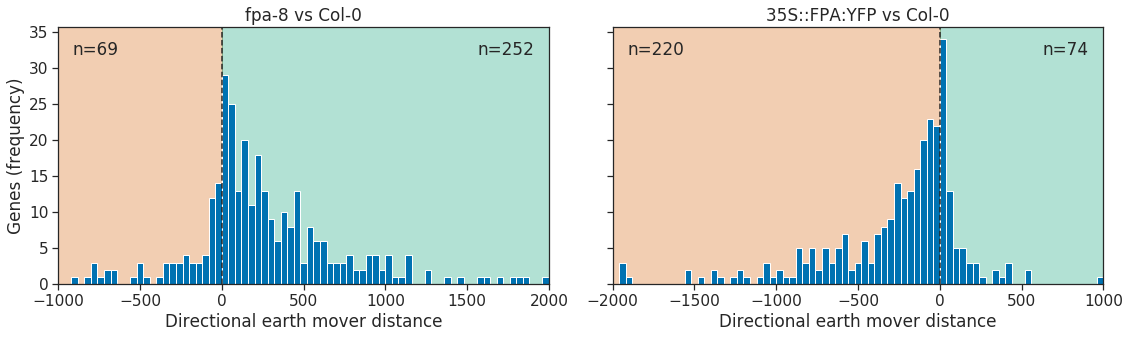

In [40]:
fig, axes = plt.subplots(figsize=(16, 5), ncols=2, sharey=True)

ax_it = zip(
    axes,
    [fpa_vs_col0, FPAox_vs_col0],
    [-1000, -2000],
    [2000, 1000],
    ['fpa-8 vs Col-0', '35S::FPA:YFP vs Col-0'],
)

for ax, df, lower_bound, upper_bound, title in ax_it:
    sig = df.query('wass_fdr < 0.05 & wass_dist > 25')
    ax.hist(sig.wass_dir, bins=75, range=(lower_bound, upper_bound))
    ax.axvline(0, ls='--', color='#252525')
    ax.axvspan(lower_bound, 0, color=pal[1], zorder=0, alpha=0.3)
    ax.axvspan(0, upper_bound, color=pal[2], zorder=0, alpha=0.3)
    ax.set_xlim(lower_bound, upper_bound)

    n_prox = len(sig.query('wass_dir < 0'))
    n_dist = len(sig.query('wass_dir > 0'))

    ax.annotate(
        xy=(0.03, 0.89),
        s=f'n={n_prox}',
        xycoords='axes fraction'
    )
    ax.annotate(
        xy=(0.97, 0.89),
        s=f'n={n_dist}',
        ha='right',
        xycoords='axes fraction',
    )
    ax.set_xlabel('Directional earth mover distance')
    ax.set_ylabel('')
    ax.set_title(title)
axes[0].set_ylabel('Genes (frequency)')
plt.tight_layout()
#plt.savefig('figures/nanopore_fpa_35FPA_APA.svg')
plt.show()

In [59]:
220 / (220 + 74)

0.7482993197278912

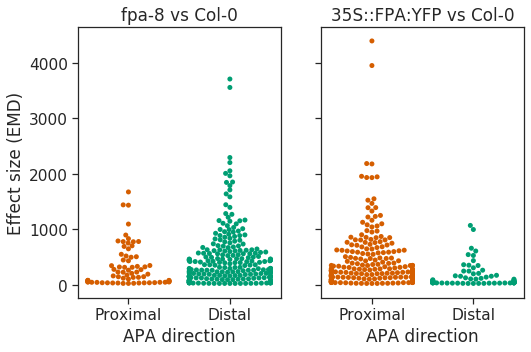

In [41]:
fig, axes = plt.subplots(figsize=(8, 5), ncols=2, sharey=True)

sns.swarmplot(
    x=fpa_vs_col0.query('wass_fdr < 0.05 & wass_dist > 25').wass_dir > 0,
    y=fpa_vs_col0.query('wass_fdr < 0.05 & wass_dist > 25').wass_dist,
    ax=axes[0],
    palette=pal[1:3]
)

sns.swarmplot(
    x=FPAox_vs_col0.query('wass_fdr < 0.05 & wass_dist > 25').wass_dir > 0,
    y=FPAox_vs_col0.query('wass_fdr < 0.05 & wass_dist > 25').wass_dist,
    ax=axes[1],
    palette=pal[1:3]
)
axes[0].set_title('fpa-8 vs Col-0')
axes[1].set_title('35S::FPA:YFP vs Col-0')
#axes[0].set_ylim(-50, 1100)
axes[0].set_ylabel('Effect size (EMD)')
axes[1].set_ylabel('')
axes[0].set_xticklabels(['Proximal', 'Distal'])
axes[1].set_xticklabels(['Proximal', 'Distal'])
axes[0].set_xlabel('APA direction')
axes[1].set_xlabel('APA direction')
plt.show()

In [44]:
genes_tested_in_both = set(fpa_vs_col0.locus_id).intersection(FPAox_vs_col0.locus_id)
fpa_distal = set(fpa_vs_col0.query('wass_fdr < 0.05 & wass_dist > 25 & wass_dir > 0').locus_id)
FPAox_proximal = set(FPAox_vs_col0.query('wass_fdr < 0.05 & wass_dist > 25 & wass_dir < 0').locus_id)

print(
    len(fpa_distal.intersection(FPAox_proximal)) - 1,
    len(genes_tested_in_both),
    len(fpa_distal.intersection(genes_tested_in_both)),
    len(FPAox_proximal.intersection(genes_tested_in_both)),
)

stats.hypergeom.sf(
    len(fpa_distal.intersection(FPAox_proximal)) - 1,
    len(genes_tested_in_both),
    len(fpa_distal.intersection(genes_tested_in_both)),
    len(FPAox_proximal.intersection(genes_tested_in_both)),
)

42 11695 252 220


2.4127507966381888e-29

In [71]:
nblrrs = pd.read_csv(
    '../../nanopore_apa_pipeline/annotations/nblrrs.txt',
    sep='\t',
)

rlps = pd.read_csv(
   '../../nanopore_apa_pipeline/annotations/rlps.txt',
    sep='\t'
)

nblrrs.head()

,gene_id,nblrr_class,locus_id
0,AT3G26470,C,RLOC_00017838
1,AT5G66630,CN-A,RLOC_00034872
2,AT1G52660,CN-B,RLOC_00005610
3,AT3G15700,CN-B,RLOC_00016497
4,AT4G19060,CN-C,RLOC_00024687


In [72]:
nblrrs[nblrrs.locus_id.isin(fpa_distal)]

,gene_id,nblrr_class,locus_id
29,AT1G63360,CNL-B4,RLOC_00006834
30,AT5G63020,CNL-B5,RLOC_00034448
42,AT3G46530,CNL-C2,RLOC_00019749
91,AT4G19510,TNL-B1,RLOC_00024740
100,AT4G19530,TNL-B2,RLOC_00024743
128,AT1G31540,TNL-F,RLOC_00003587
134,AT3G44670,TNL-G2,RLOC_00019477
139,AT1G69550,TNL-G3,RLOC_00007607
142,AT2G14080,TNL-G3,RLOC_00010554
164,AT1G63740,TNL-H,RLOC_00006873


In [73]:
nblrrs[nblrrs.locus_id.isin(FPAox_proximal)]

,gene_id,nblrr_class,locus_id
42,AT3G46530,CNL-C2,RLOC_00019749
49,AT5G48620,CNL-D,RLOC_00032750
55,AT1G58602,CNL-D,RLOC_00006322
74,AT4G16990,TN,RLOC_00024419
81,AT4G19520,TNL-A-TNLTX,RLOC_00024741
85,AT4G36140,TNL-A-TNTNL,RLOC_00026745
88,AT4G36140,TNL-A,RLOC_00026745
128,AT1G31540,TNL-F,RLOC_00003587
131,AT5G46270,TNL-F,RLOC_00032473
134,AT3G44670,TNL-G2,RLOC_00019477


In [74]:
rlps[rlps.locus_id.isin(fpa_distal)]

,gene_id,gene_name,locus_id
18,AT2G15080,AtRLP19,RLOC_00010710
34,AT3G11080,AtRLP35,RLOC_00015907


In [75]:
rlps[rlps.locus_id.isin(FPAox_proximal)]

,gene_id,gene_name,locus_id
29,AT3G05360,AtRLP30,RLOC_00015273


In [45]:
with pd.ExcelWriter('./helicos_fpa8_35SFPA_alternative_polya.xlsx') as xl:
    fpa_vs_col0.query('wass_fdr < 0.05 & wass_dist > 25 & wass_dir > 0').to_excel(xl, sheet_name='fpa8_distal')
    fpa_vs_col0.query('wass_fdr < 0.05 & wass_dist > 25 & wass_dir < 0').to_excel(xl, sheet_name='fpa8_proximal')
    FPAox_vs_col0.query('wass_fdr < 0.05 & wass_dist > 25 & wass_dir > 0').to_excel(xl, sheet_name='35SFPA_distal')
    FPAox_vs_col0.query('wass_fdr < 0.05 & wass_dist > 25 & wass_dir < 0').to_excel(xl, sheet_name='35SFPA_proximal')